# Imports

In [2]:
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.drift_detection import ADWIN
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.data import FileStream
from skmultiflow.metrics import ConfusionMatrix
from skmultiflow.core import Pipeline
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import Counter
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
%matplotlib notebook

In [4]:
df = pd.read_csv('final_dataset.csv')

X = df.drop(['Label'], axis=1).to_numpy()
y = df['Label'].to_numpy()

#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import NearMiss

#X_nearmiss, y_nearmiss = NearMiss().fit_sample(X, y)

#df = pd.concat([pd.DataFrame(X_nearmiss, columns=X.columns), pd.Series(y_nearmiss, name='Label')], axis=1)

#df = df.sample(frac=1, random_state=1).reset_index(drop=True)

#df.to_csv('labeled_data_balanced.csv', index=False, header=True)

# Hoeffding Trees

## Original data set (imbalanced 10%)

### W/ Subdom levels feature

In [27]:
st1 = FileStream('labeled_data.csv')

ht1 = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 50000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st1.next_sample()        # get the next sample
    prediction = ht1.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht1.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:09<00:00, 5234.81it/s]


#### Evaluator

In [50]:
correctness_dist.count(1)/len(correctness_dist)

0.97688

<IPython.core.display.Javascript object>


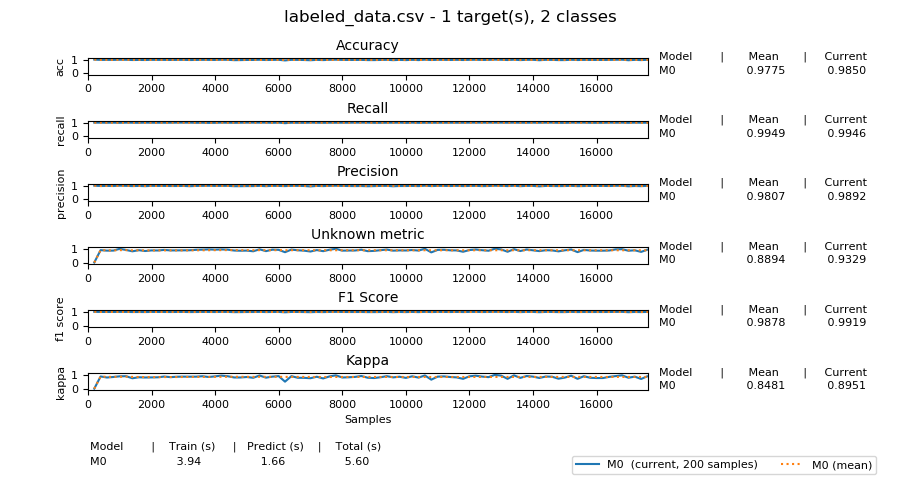

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [9.97s]
Processed samples: 17616
Mean performance:
M0 - Accuracy     : 0.9775
M0 - Kappa        : 0.8481
M0 - Precision: 0.9807
M0 - Recall: 0.9949
M0 - F1 score: 0.9878
M0 - Training time (s)  : 3.94
M0 - Testing time  (s)  : 1.66
M0 - Total time    (s)  : 5.60


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [56]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              data_points_for_classification=False,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision','gmean' ,'f1', 'kappa', 'running_time'])
evaluator.evaluate(stream=st1, model=ht1)

#### Unlabeled

In [3]:
stream_unlab = FileStream('unlabeled_data.csv')

predictions_sd = []

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('unlabeled_data.csv')))):
    X, Y = stream_unlab.next_sample()        # get the next sample
    y_pred = ht1.predict(X)       # predict Y using the tree     
    predictions.append(y_pred[0])   
    ht1.partial_fit(X, y_pred)             # update the tree

100%|████████████████████████████████████████████████████████████████████████| 365383/365383 [01:53<00:00, 3227.29it/s]


In [11]:
predictions_sd = pd.Series(predictions_sd, name='Labeled with subdomains')

### W/O subdom levels feature

In [57]:
# 1. Create a stream
st2 = FileStream('labeled_data_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht2 = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 50000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st2.next_sample()        # get the next sample
    prediction = ht2.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht2.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:16<00:00, 3087.74it/s]


#### Evalator

<IPython.core.display.Javascript object>


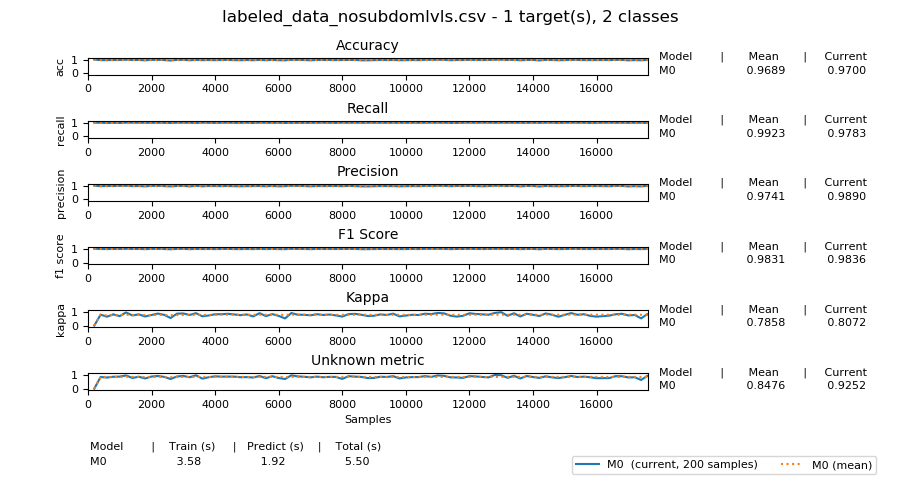

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [9.49s]
Processed samples: 17616
Mean performance:
M0 - Accuracy     : 0.9689
M0 - Kappa        : 0.7858
M0 - Precision: 0.9741
M0 - Recall: 0.9923
M0 - F1 score: 0.9831
M0 - Training time (s)  : 3.58
M0 - Testing time  (s)  : 1.92
M0 - Total time    (s)  : 5.50


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [58]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st2, model=ht2)

#### Unlabeled

In [12]:
stream_unlab_nosd = FileStream('unlabeled_data_nosubdomlvls.csv')

predictions_nosd = []

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('unlabeled_data_nosubdomlvls.csv')))):
    X, Y = stream_unlab_nosd.next_sample()        # get the next sample
    y_pred = ht2.predict(X)       # predict Y using the tree     
    predictions_nosd.append(y_pred[0])   
    ht2.partial_fit(X, y_pred)             # update the tree

100%|████████████████████████████████████████████████████████████████████████| 365383/365383 [01:50<00:00, 3318.00it/s]


In [13]:
predictions_nosd = pd.Series(predictions_nosd, name='Labeled w/o subdomains')

In [14]:
ul = pd.read_csv('final_unlabeled.csv')['Domain']
df = pd.concat([pd.Series(ul, name='Domain'), predictions_sd, predictions_nosd], axis=1)

In [15]:
df.to_csv('unlabeled_predictions.csv', index=False, header=True)

## Imbalanced 25%

### W/ Subdom levels feature

In [32]:
# 1. Create a stream
st3 = FileStream('labeled_data_25.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht3 = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 20000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st3.next_sample()        # get the next sample
    prediction = ht3.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht3.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 5032.30it/s]


#### Evaluator

<IPython.core.display.Javascript object>


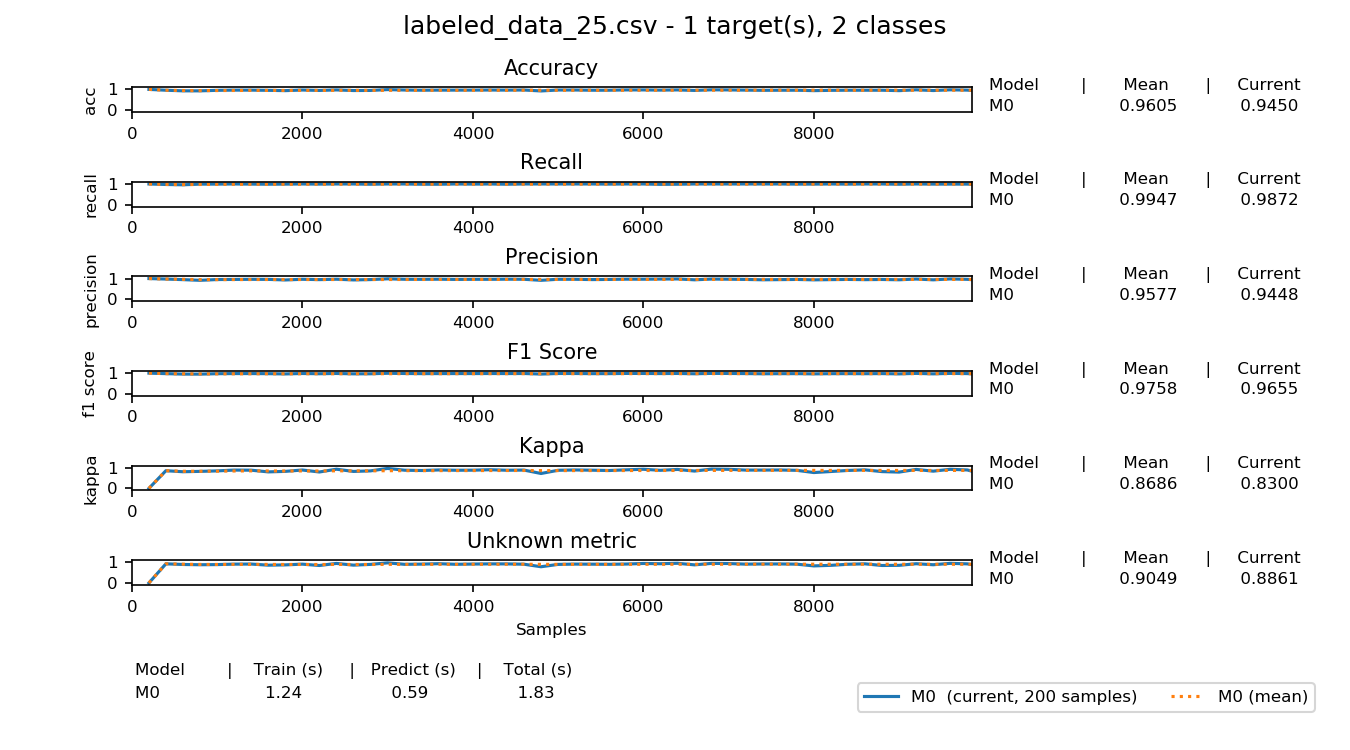

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [3.22s]
Processed samples: 9855
Mean performance:
M0 - Accuracy     : 0.9605
M0 - Kappa        : 0.8686
M0 - Precision: 0.9577
M0 - Recall: 0.9947
M0 - F1 score: 0.9758
M0 - Training time (s)  : 1.24
M0 - Testing time  (s)  : 0.59
M0 - Total time    (s)  : 1.83


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [29]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st3, model=ht3)

#### Unlabeled

In [33]:
stream_unlab = FileStream('unlabeled_data.csv')

predictions = []

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('unlabeled_data.csv')))):
    X, Y = stream_unlab.next_sample()        # get the next sample
    y_pred = ht3.predict(X)       # predict Y using the tree     
    predictions.append(y_pred[0])   
    ht3.partial_fit(X, y_pred)             # update the tree

100%|████████████████████████████████████████████████████████████████████████| 365383/365383 [01:00<00:00, 6021.12it/s]


In [34]:
Counter(predictions)

Counter({0: 356283, 1: 9100})

### W/O subdom levels feature

In [25]:
# 1. Create a stream
st4 = FileStream('labeled_data_25_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht4 = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 20000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st4.next_sample()        # get the next sample
    prediction = ht4.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht4.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 5056.41it/s]


#### Evalator

<IPython.core.display.Javascript object>


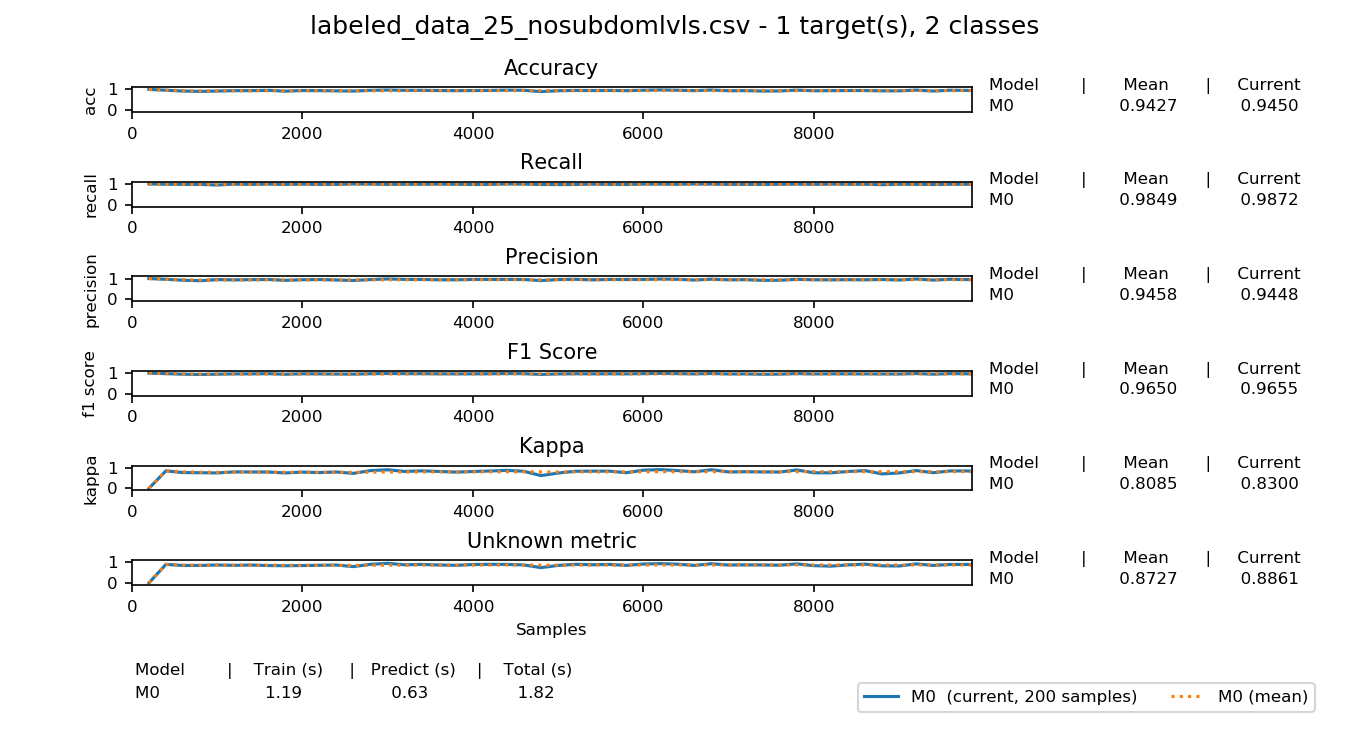

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [3.23s]
Processed samples: 9855
Mean performance:
M0 - Accuracy     : 0.9427
M0 - Kappa        : 0.8085
M0 - Precision: 0.9458
M0 - Recall: 0.9849
M0 - F1 score: 0.9650
M0 - Training time (s)  : 1.19
M0 - Testing time  (s)  : 0.63
M0 - Total time    (s)  : 1.82


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [27]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st4, model=ht4)

## Balanced data set

### W/ Subdom levels feature

In [35]:
# 1. Create a stream
st5 = FileStream('labeled_data_balanced.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht5 = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 10000

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('labeled_data_balanced.csv')))):
    X, Y = st5.next_sample()        # get the next sample
    prediction = ht5.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht5.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 11942/11942 [00:02<00:00, 5300.58it/s]


In [18]:
correctness_dist.count(1)/len(correctness_dist)

0.9093954111539105

#### Evaluator

In [ ]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st5, model=ht5)

In [38]:
stream_unlab = FileStream('unlabeled_data.csv')

predictions = []

getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(len(pd.read_csv('unlabeled_data.csv')))):
    X, Y = stream_unlab.next_sample()  # get the next sample
    y_pred = ht5.predict(X)       # predict Y using the tree     
    predictions.append(y_pred[0])   
    ht5.partial_fit(X, y_pred)             # update the tree

100%|████████████████████████████████████████████████████████████████████████| 365383/365383 [00:58<00:00, 6248.43it/s]


In [39]:
Counter(predictions)

Counter({0: 362303, 1: 3080})

In [21]:
predictions = pd.Series(predictions, name='ht_balanced_sd')

In [22]:
ul = pd.read_csv('unlabeled_predictions.csv')
df = pd.concat([ul, predictions], axis=1)

In [23]:
df.to_csv('unlabeled_predictions.csv', index=False, header=True)

### W/O subdom levels feature

In [15]:
# 1. Create a stream
st6 = FileStream('labeled_data_balanced_nosubdomlvls.csv')

# 2. Instantiate the HoeffdingTreeClassifier
ht6 = HoeffdingTreeClassifier()


correctness_dist = []
nb_iters = 10000
getattr(tqdm, '_instances', {}).clear()
for i in tqdm(range(nb_iters)):
    X, Y = st6.next_sample()        # get the next sample
    prediction = ht6.predict(X)       # predict Y using the tree     
    if Y == prediction:                # check the prediction
        correctness_dist.append(1)
    else:
        correctness_dist.append(0)   
    ht6.partial_fit(X, Y)             # update the tree

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4703.12it/s]


In [54]:
correctness_dist.count(1)/len(correctness_dist)

0.8728

#### Evaluator

<IPython.core.display.Javascript object>


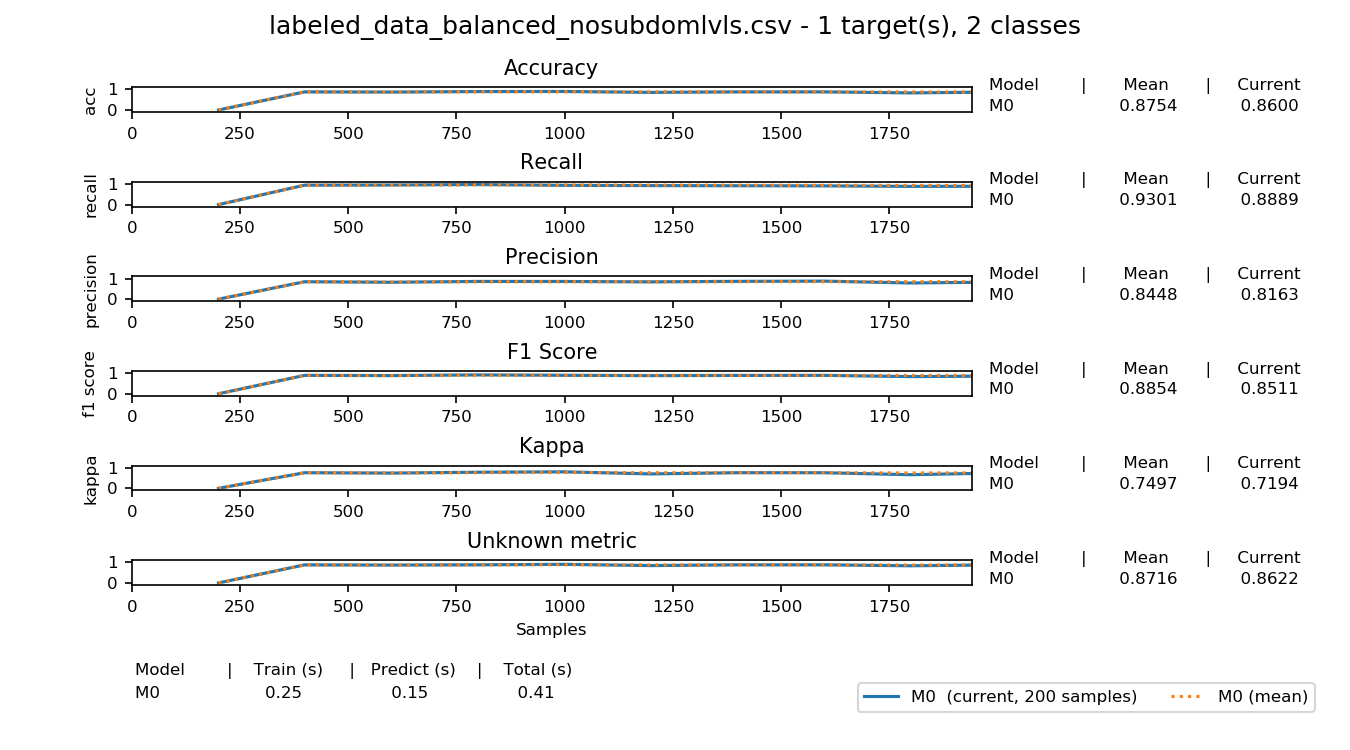

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [0.73s]
Processed samples: 1942
Mean performance:
M0 - Accuracy     : 0.8754
M0 - Kappa        : 0.7497
M0 - Precision: 0.8448
M0 - Recall: 0.9301
M0 - F1 score: 0.8854
M0 - Training time (s)  : 0.25
M0 - Testing time  (s)  : 0.15
M0 - Total time    (s)  : 0.41


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [16]:
%matplotlib notebook
evaluator=EvaluatePrequential(show_plot=True,
                              max_samples=nb_iters,
                             metrics=['accuracy', 'recall', 'precision', 'f1', 'kappa', 'gmean', 'running_time'])
evaluator.evaluate(stream=st6, model=ht6)